# **Exploring Profit Potential and Performance Metrics in a Trading Model**

## Table of Contents

- Problem Definition
- Data Source
- Data munging
- Data cleaning
- Exploration of dataset
- The Ordinary Least Square (OLS) Regression
- Evaluation of the trading strategy
- References


## Problem Definition

The project aims to design and implement a Multiple Linear Regression model that generates signals for predicting the growth of the `SPY` (Exchange-Traded Fund tracking the `S&P500`) based on a diverse set of global market indices. The primary focus is on predicting price changes in `SPY`, a cost-effective and frequently traded asset with close ties to the `S&P500` index.

The global market indices that will be utilized for the model are:



1.   US Markets
      - `SPY`
      - `S&P500`
      - `NASDAQ`
      - `Dji`
2.   EU Markets
      - `CAC40` (France)
      - `DAX` (Germany)
3.   Asian & Australian Markets
      - `Aord` (Australia)
      - `HSI` (Hong Kong)
      - `Nikkei` (Japan)





## Data Source

This project has been done by utilizing the coursera course titled 'Python and Statistics for Financial Analysis'. The datasets used for this project have been extracted from Yahoo Finance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
aord=pd.read_csv('/content/ALLOrdinary.csv')
nikkei=pd.read_csv('/content/Nikkei225.csv')
hsi=pd.read_csv('/content/HSI.csv')
daxi=pd.read_csv('/content/DAXI.csv')
cac40=pd.read_csv('/content/CAC40.csv')
sp500=pd.read_csv('/content/SP500.csv')
dji=pd.read_csv('/content/DJI.csv')
nasdaq=pd.read_csv('/content/nasdaq_composite.csv')
spy=pd.read_csv('/content/SPY.csv')

In [3]:
#To check the index of each of the files
print(aord.head(1),nikkei.head(1),hsi.head(1),daxi.head(1),cac40.head(1),sp500.head(1),dji.head(1),nasdaq.head(1),spy.head(1))

         Date         Open         High          Low        Close  \
0  2008-01-01  6418.600098  6462.799805  6408.399902  6434.100098   

     Adj Close       Volume  
0  6434.100098  365493500.0            Date          Open          High           Low         Close  \
0  2008-01-04  15155.730469  15156.660156  14542.580078  14691.410156   

      Adj Close   Volume  
0  14691.410156  98700.0            Date          Open          High           Low         Close  \
0  2008-01-02  27632.199219  27853.599609  27299.449219  27560.519531   

      Adj Close        Volume  
0  27560.519531  1.232143e+09            Date         Open         High          Low        Close  \
0  2008-01-02  8045.970215  8100.640137  7925.109863  7949.109863   

     Adj Close       Volume  
0  7949.109863  110721200.0            Date        Open         High          Low        Close    Adj Close  \
0  2008-01-02  5609.97998  5665.939941  5530.430176  5550.359863  5550.359863   

        Volume  
0  1004582

In [4]:
#To reset the index of each of the files to the 'Date' variable
spy.set_index('Date',inplace=True)
aord.set_index('Date',inplace=True)
nikkei.set_index('Date',inplace=True)
hsi.set_index('Date',inplace=True)
daxi.set_index('Date',inplace=True)
cac40.set_index('Date',inplace=True)
sp500.set_index('Date',inplace=True)
dji.set_index('Date',inplace=True)
nasdaq.set_index('Date',inplace=True)

In [5]:
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,146.529999,146.990005,143.880005,144.929993,116.593864,204935600
2008-01-03,144.910004,145.490005,144.070007,144.860001,116.537567,125133300
2008-01-04,143.339996,143.440002,140.910004,141.309998,113.681671,232330900
2008-01-07,141.809998,142.229996,140.100006,141.190002,113.585121,234991000
2008-01-08,142.080002,142.899994,138.440002,138.910004,111.750923,326365700
...,...,...,...,...,...,...
2018-08-15,282.380005,282.540009,280.160004,281.779999,281.779999,102925400
2018-08-16,283.399994,285.040009,283.359985,284.059998,284.059998,69967900
2018-08-17,283.829987,285.559998,283.369995,285.059998,285.059998,65618500


## Data Munging

A crucial thing to be noted is that we are trying to predict the data price change of `SPY` when US markets open in the morning; the high autocorrelation between different indices in different markets will help achieve this. However, the different markets operate in different time zones. For instance, the US market operates from 9:00AM-4:00PM EST, European markets operates from 3:00AM-11:30AM EST same day, and Asian markets, including Australian market, operate from 8:00PM EST (previous day) to 11:30AM EST (same day), implying that the Asian market information is available for the US market at its opening, unlike the rest of the markets.

Keeping this in mind, it is crucial to extract and calculate appropriate stock market data for analysis.

Therefore, the predictors that will be used for the model are following:

- USA Market
    - `SPY`: Open Price- Open price of last day
    - `SP500`: Open Price- Open price of last day
    - `NASDAQ`: Open Price- Open price of last day
    - `DJI`: Open Price- Open price of last day
- EU Markets:
    - `CAC40`: Open Price- Open price of last day
    - `Daxi`: Open Price- Open price of last day
- Asian & Australin Markets:
    - `Aord`: Close- Open price
    - `HSI`: Close-Open price
    - `Nikkei`: Close-Open price
    
And the response variable will be `SPY = Open price of next day- Open price`.


In [6]:
#Denote the dataframe for the trading model by indice
indice=pd.DataFrame(index=spy.index)  #setting the index same as that of SPY

It is important to keep in mind that the open price of the stocks does not depend on the closing price of the previous day as the after-hours trading can change the investor valuations or expectations for the security.


In [7]:
indice['spy']=spy['Open'].shift(-1)-spy['Open'] # note that .shift(-1) shifts all the entries by 1 in upward direction. Unlike the other cases, we are trying to predict tommorow's price of SPY using other indices, therefore we are using open(today)
indice['spy_lag1']=indice['spy'].shift(1)
indice['sp500']=sp500['Open']-sp500['Open'].shift(1) # note that .shift(1) shifts all the entries by 1 in downward direction
indice['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indice['dji']=dji['Open']-dji['Open'].shift(1)

indice['cac40']=cac40['Open']-cac40['Open'].shift(1)
indice['daxi']=daxi['Open']-daxi['Open'].shift(1)

indice['aord']=aord['Close']-aord['Open']
indice['hsi']=hsi['Close']-hsi['Open']
indice['nikkei']=nikkei['Close']-nikkei['Open']
indice['Price']=spy['Open']

In [8]:
indice.head(5)

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,-50.100097,-71.679688,NaN,146.529999
2008-01-03,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-2.300293,-162.750000,NaN,144.910004
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,NaN,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002


## Data Cleaning

In [9]:
indice.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

It can be seen that `.shit()` has created some null values due to lack of information regarding the Open/ Close price due to timezone variances. Accordingly, it is crucial to deal with these values before plunging into the modelling portion.

In [10]:
#Shifting the last valid observation forward to next valid
indice = indice.fillna(method = 'ffill')

#Dropping the first row using dropna()
indice = indice.dropna()

#Checking for null values
indice.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [11]:
indice. shape

(2677, 11)

It should be noted that as per the shape of the dataframe, it can be assumed that the total number of days being considered for the model are 2676, one response variable, nine predictors, and the last column keeps a record of open price of SPY, which will be used in paper trading.

As the stock data is pretty volatile, and therefore prone to a lot of noise, the split into training and testing dataset will be done in equal parts.

In [12]:
train = indice.iloc[-2000:-1000, :]
test = indice.iloc[-1000:, :]
print(train.shape, test.shape)

(1000, 11) (1000, 11)


## Exploration of Dataset

To observe the association between the variables, the correlation matrix shall be plotted to get an overview of how the variables play together.

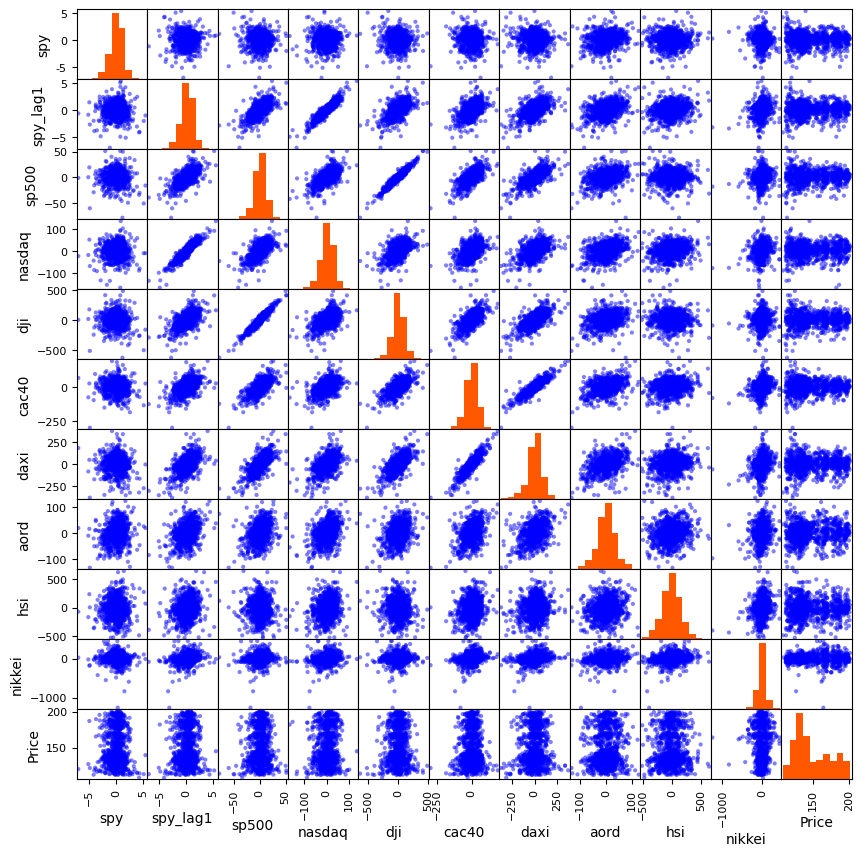

In [13]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(train, figsize=(10, 10), color='blue', diagonal='hist', hist_kwds={'color': '#ff5800'})

In consistency with the noisy aspect of stocks, it can be seen that there is no apparent/ explicit pattern between the variables.

Accordingly, the correlation can be computed for relatively better understanding.

In [14]:
train.iloc[:, :-1].corr()['spy']

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64

It seems `DJI` has an association with `SPY`, but both are negatively correlated.

It is important to note that the correlation is really close to 0, which indicates that the correlation is not that strong

## The Ordinary Least Square Regression


OLS regression is like finding the best line that explains how one thing (the dependent variable) changes when other things (independent variables) change. It aims to minimize the errors in predicting actual outcomes with a mathematical equation. The goal is to have a line that closely fits the real data points.

In [15]:
pip install tabulate


In [16]:
from tabulate import tabulate

In [17]:
formula = 'spy~spy_lag1+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=train).fit()
print(tabulate(lm.summary().tables[0], headers='keys', tablefmt='github'))
print()
print()
print(tabulate(lm.summary().tables[1], headers='keys', tablefmt='github'))
print()
print()
print(tabulate(lm.summary().tables[2], headers='keys', tablefmt='github'))

| 0                 | 1                | 2                   | 3        |
|-------------------|------------------|---------------------|----------|
| Dep. Variable:    | spy              | R-squared:          | 0.065    |
| Model:            | OLS              | Adj. R-squared:     | 0.057    |
| Method:           | Least Squares    | F-statistic:        | 8.615    |
| Date:             | Sat, 20 Jan 2024 | Prob (F-statistic): | 2.10e-11 |
| Time:             | 18:55:54         | Log-Likelihood:     | -1619.1  |
| No. Observations: | 1000             | AIC:                | 3256.    |
| Df Residuals:     | 991              | BIC:                | 3300.    |
| Df Model:         | 8                |                     |          |
| Covariance Type:  | nonrobust        |                     |          |


| 0         | 1         | 2       | 3      | 4     | 5      | 6      |
|-----------|-----------|---------|--------|-------|--------|--------|
|           | coef      | std err | t     

From the results tables the following can be understood:

- Thre regression equation is `spy=0.0852 + (-0.1737)*spy_lag1 + (0.0063)*nasdaq + (0.0004)+dji+(7.198e-06)*cac40 + (0.0093)*aord+(-0.0026)*daxi+(-0.0004)*nikkei+(0.0003)*hsi`.

- From the `P-value` test, we can certify that only the predictors `aord` and `daxi` fall above the threshold value of 0.05 implying that they have high significance as individual predictors on the target variable.


- `Durbin- Watson`: This value denotes the autocorrelation in the residuals from the regression analysis. Traditionally, the value lies between 0 and 4, with 2 denoting no autocorrelation, 0 to 2 denoting a positive autocorrelation and a value of 2 to 4 denoting a negative autocorrelation. In this case, it can be seen that the value is greater than 2 and therefore implies a case of negative autocorrelation. This would mean that the if the previous day price fell, then there's a high chance that the stock price will rise today.



### Model Evaluation

Now, to evaluate the performance of the model, two metrics will be utilized- $\text{RMSE}$ and $\text{Adjusted }R^{2}$

The two are mathematically given as:
- $RMSE= \sqrt{\frac{SSE}{n-k-1}}$

- $\text{Adjusted }R^{2}= 1-\frac{(1-R^2)(n-1)}{n-k-1}$

Over here $n$ denotes the number of observation and $y$ denotes the number of predictors.


In [27]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [28]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [31]:
assessTable(test, train, lm, 9, 'spy')

<ipython-input-27-ed95672825d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)
<ipython-input-27-ed95672825d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)


,Train,Test
R2,0.056523,0.066040
RMSE,1.227694,1.708188


The model exhibits a limited ability to explain the variability in the dependent variable, as indicated by the low $R^2$ values. Additionally, there is a noticeable difference in performance between the training and test datasets, suggesting potential overfitting to the training data. Further model refinement and validation may be necessary to improve its generalization to new data. Consideration should be given to exploring alternative model specifications or incorporating additional features to enhance predictive accuracy and robustness.

## Evaluation of the trading startegy


In [35]:
train_copy = train.copy()
test_copy = test.copy()

train_copy['Predicted_Y'] = lm.predict(train_copy)
test_copy['Predicted_Y'] = lm.predict(test_copy)



### Signal Based Strategy

To evaluate the performance of the model by using a signal based strategy, the  price change of SPY will be predicted as a trading signal.

The variable `Order` is computed as equal to 1 if predicted value is positive, that is, the prediction for price change is positive for opening today to opening tomorrow, and conversely it is equated to -1.

In [36]:
train_copy['Order'] = [1 if sig>0 else -1 for sig in train_copy['Predicted_Y']]
train_copy['Profit'] = train_copy['spy'] * train_copy['Order']

train_copy['Wealth'] = train_copy['Profit'].cumsum()
print('Total profit made in Train: ', train_copy['Profit'].sum())

Total profit made in Train:  199.66010900000038


Now, two strategies will be compared- *Signal based strategy* and *Buy & Hold Strategy* to see which would perform better.
The *Buy & Hold Strategy* is to basically buy more shares of SPY and hold them for 1000 days.

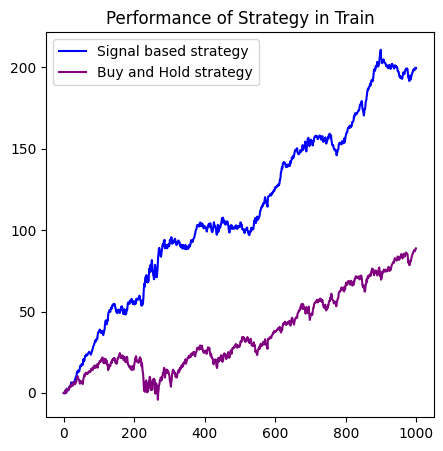

In [41]:
plt.figure(figsize=(5, 5))
plt.title('Performance of Strategy in Train')
plt.plot(train_copy['Wealth'].values, color='blue', label='Signal based strategy')
plt.plot(train_copy['spy'].cumsum().values, color='purple', label='Buy and Hold strategy')
plt.legend()
plt.show()

It can be seen from the plot that the *Signal Based Strategy* outperforms *Buy and Hold Strategy* in the long run.

In [43]:
test_copy['Order'] = [1 if sig>0 else -1 for sig in test_copy['Predicted_Y']]
test_copy['Profit'] = test_copy['spy'] * test_copy['Order']

test_copy['Wealth'] = test_copy['Profit'].cumsum()
print('Total profit made in Test: ', test_copy['Profit'].sum())

Total profit made in Test:  266.61010199999987


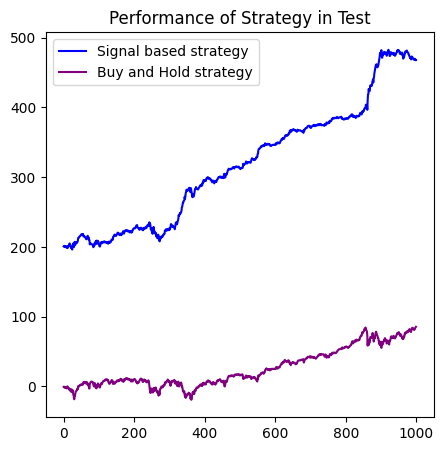

In [53]:
plt.figure(figsize=(5, 5))
plt.title('Performance of Strategy in Test')
plt.plot(test_copy['Wealth'].values, color='blue', label='Signal based strategy')
plt.plot(test_copy['spy'].cumsum().values, color='purple', label='Buy and Hold strategy')
plt.legend()
plt.show()

From the above analysis, the following can be concluded:

- The total profit earned in Training data is approximately 199.6602 whereas for the Testing data is approximately 266.610.

- For both training and testing datasets, Signal Based Strategy outperforms Buy and Hold Strategy in the long run.

### Evaluating using Sharpe Ratio & Maximum Drawdown

The two metrics that will be utilized for this evaluation are explained as follows:

- *Sharpe Ratio* measures the excess return or risk premium per unit of deviation in an investment asset or trading.
 $\text{Sharpe Ratio}=\frac{\text{Mean of excess return}}{\text{Standard Deviation of excess return}}$

- *Maximum Drawdown* measures the maximum percentage decline in theb strategy from the historical peak profit at each point in time.
 $\text{Maximum Drawdown}=\frac{\text{Maximum- Wealth}}{\text{Maximum}}$

First, the feature `Wealth` will be revised by includingt he inital investment, which is equivalent to the price of one share of SPY.

In [47]:
train_copy['Wealth'] = train_copy['Wealth'] + train_copy.loc[train_copy.index[0], 'Price']
test_copy['Wealth'] = test_copy['Wealth'] + test_copy.loc[test_copy.index[0], 'Price']

To make the values more interpretable, and normalized, it is essential to utilize the `np.log` funciton.

In [48]:
train_copy['Return'] = np.log(train_copy['Wealth']) - np.log(train_copy['Wealth'].shift(1)) #calculates difference between the logarithm of the wealth and the logarithm of the previous day's wealth
dailyr = train_copy['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.16708226929555478
Yearly Sharpe Ratio is  2.6523487982661664


In [49]:
test_copy['Return'] = np.log(test_copy['Wealth']) - np.log(test_copy['Wealth'].shift(1))
dailyr = test_copy['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.139902560725038
Yearly Sharpe Ratio is  2.220884300757377


In [51]:
train_copy['Peak'] = train_copy['Wealth'].cummax()
train_copy['Drawdown'] = (train_copy['Peak'] - train_copy['Wealth'])/train_copy['Peak']
print('Maximum Drawdown in Train is ', train_copy['Drawdown'].max())

Maximum Drawdown in Train is  0.060716873924393545


In [52]:
test_copy['Peak'] = test_copy['Wealth'].cummax()
test_copy['Drawdown'] = (test_copy['Peak'] - test_copy['Wealth'])/test_copy['Peak']
print('Maximum Drawdown in Test is ', test_copy['Drawdown'].max())

Maximum Drawdown in Test is  0.11569689595111983


From the above analysis, it can be concluded that:

- Yearly *Sharpe ratio* is 2.65 for training data and 2.22 for test data, signifying that it is much lower than that of the train.

- The *Maximum Drawdown* aren't that close, implying that the model's performance or risk characteristics are not consistent across different periods.

## References


- This project was inspired from the Coursera course *Python and Statistics for Financial Analysis by Hong Kong University*.

- https://www.investopedia.com/ was utilized for understanding basic terms involved in Trading, Statistics and Financial Analysis.